In [1]:
#imports
import math
import jax
import jax.numpy as jnp
from jax.experimental.ode import odeint
import numpy as np
from functools import partial
import matplotlib.pyplot as plt
from jax.example_libraries import stax
from jax.example_libraries import optimizers



In [2]:
#Definicja Lagrangianu dla pojedynńczego wachadła liczonego w sposób analityczny
#Argumenty funkcji:
#  -q   - położenie ciała
#  -q_t - prędkość ciała
#  -m   - masa ciała
#  -l   - długość liny
#  -g   - wartość przyśpieszenia ziemskiego
#Zwracane: wartość Lagrangianu w danym momencie.
def lagrangian_analitical(q, q_t, m, l, g):
    #Eneriga kinetyczna
    Ek=0.5*m*l*jnp.square(q_t)
    
    #Energia potencjalna
    Ep=m*g*(l-l*jnp.cos(q))
    
    #Lagrangian
    return jnp.sum(Ek - Ep)

#Funkcja ma za zadanie reprezenotwanie równania różniczkowego, wynikającego z rozwiązania
#równanie Eulera-Lagrange'a
#Argumenty funkcji:
#   -lagrangian - Funkcja opisująca Lagrangian. Funkcja musi być typu ,,callable'' żeby,
#                 pochodne Lagrangianu zostały policzone.
#   -state      - Wektor zawierający wartości początkowe położenia i prędkości
#   -empty      - Aby ta funkcja mogła zostać poprawnie wywoływana w dalszej części programu
#                 koniecznym było dodanie ,,pustego'' argumentu, które nie będzie pełnił żadnej
#                 funkcji, ale pozwoli na poprawną kompilację
#Zwracane: Wektor zawiercający przyśpieszenia oraz prędkości w danym momencie.
def equation_of_motion(lagrangian, state, empty=None):
    #Rozdzilenie danych startowych na położenia i prędkości
    q, q_t = jnp.split(state, 2)
    
    #Obliczanie przyśpieszenia na podstawie lagrangianu
    q_tt = (jnp.linalg.pinv(jax.hessian(lagrangian, 1)(q, q_t))
          @ (jax.grad(lagrangian, 0)(q, q_t)
             - jax.jacobian(jax.jacobian(lagrangian, 1), 0)(q, q_t) @ q_t))
    return jnp.concatenate([q_t, q_tt])

#Funkcja wyznaczająca równanie ruchu przy użyciu Lagrangianu wyznaczonego
#w sposób analityczny
#Argumenty funkcji:
#   -initial_state - Początkowego położenie oraz prędkości
#   -times         - Czas wyznaczanej trajektori
#   -m             - masa wachadła
#   -l             - długość liny wachadła
#   -g             - przyśpieszenie ziemskie
@partial(jax.jit, backend='cpu')
def solve_autograd(initial_state, times, m=1, l=1, g=9.8):
  lagrangian = partial(lagrangian_analitical, m=m, l=l, g=g)
  equation = partial(equation_of_motion, lagrangian)
  return odeint(equation, initial_state, times, rtol=1e-10, atol=1e-10)

In [3]:
def analitical(initial_state, empty=None, l=1, g=9.8):
    q = initial_state[0]
    q_t = initial_state[1]
    q_tt = -g / l * jnp.sin(q)
    return jnp.concatenate((jnp.expand_dims(q_t, axis=0), jnp.expand_dims(q_tt, axis=0)), axis=0)

@partial(jax.jit, backend='cpu')
def solve_analitical(initial_state, times, l=1, g=9.8):
    function = partial(analitical, l=l, g=g)
    return odeint(function, initial_state, t=times, rtol=1e-10, atol=1e-10)

In [4]:
x0 = jnp.array([0,0.2], dtype=np.float32)
noise = np.random.RandomState(0).randn(x0.size)
t = np.linspace(0, 40, num=401, dtype=np.float32)

In [5]:
%time autograd_clean = jax.device_get(solve_autograd(x0, t))
%time autograd_noise1 = jax.device_get(solve_autograd(x0 + 1e-10*noise, t))
%time autograd_noise2 = jax.device_get(solve_autograd(x0 + 1e-2*noise, t))

%time analitical_clean = jax.device_get(solve_analitical(x0, t))
%time analitical_noise1 = jax.device_get(solve_analitical(x0 + 1e-10*noise, t))
%time analitical_noise2 = jax.device_get(solve_analitical(x0 + 1e-2*noise, t))

CPU times: user 848 ms, sys: 192 ms, total: 1.04 s
Wall time: 831 ms
CPU times: user 21.7 ms, sys: 387 µs, total: 22.1 ms
Wall time: 30.4 ms
CPU times: user 1.56 ms, sys: 0 ns, total: 1.56 ms
Wall time: 1.22 ms
CPU times: user 384 ms, sys: 673 µs, total: 385 ms
Wall time: 380 ms
CPU times: user 1.9 ms, sys: 409 µs, total: 2.3 ms
Wall time: 1.62 ms
CPU times: user 1.57 ms, sys: 340 µs, total: 1.91 ms
Wall time: 1.51 ms


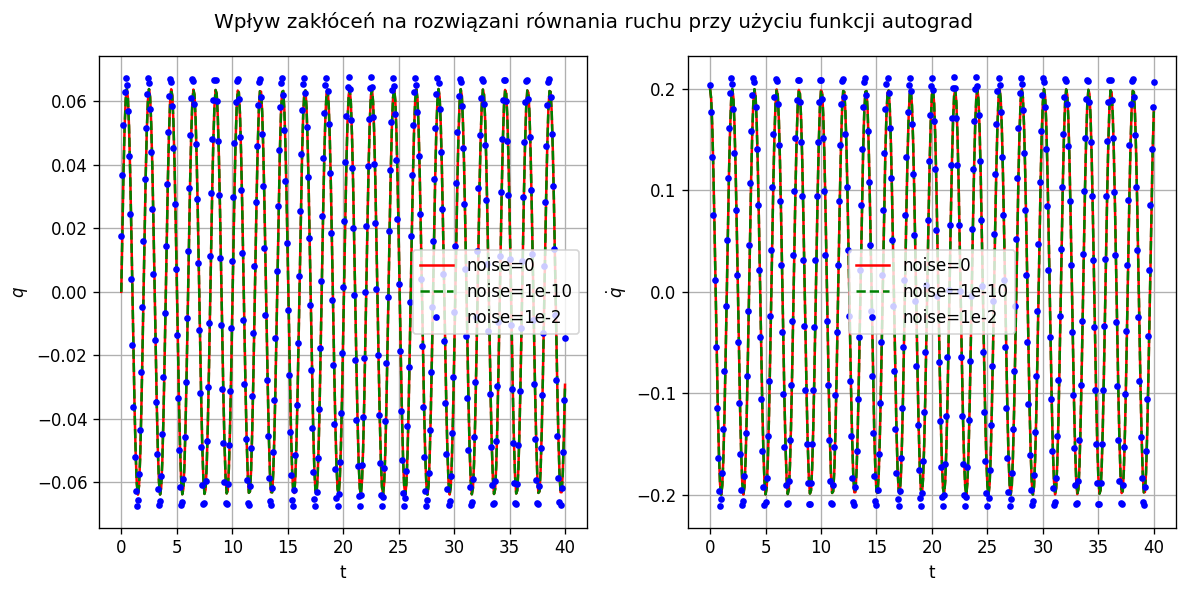

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=120)

fig.suptitle("Wpływ zakłóceń na rozwiązani równania ruchu przy użyciu funkcji autograd")

axes[0].plot(t, autograd_clean[:, 0], 'r', label='noise=0')
axes[0].plot(t, autograd_noise1[:, 0], 'g--', label='noise=1e-10')
axes[0].plot(t, autograd_noise2[:, 0], 'b.', label='noise=1e-2')
axes[0].set_xlabel('t')
axes[0].set_ylabel('$q$')
axes[0].legend()
axes[0].grid()


axes[1].plot(t, autograd_clean[:, 1], 'r', label='noise=0')
axes[1].plot(t, autograd_noise1[:, 1], 'g--', label='noise=1e-10')
axes[1].plot(t, autograd_noise2[:, 1], 'b.', label='noise=1e-2')
axes[1].set_xlabel('t')
axes[1].set_ylabel('$\dot q$')
axes[1].legend()
axes[1].grid()

plt.tight_layout()






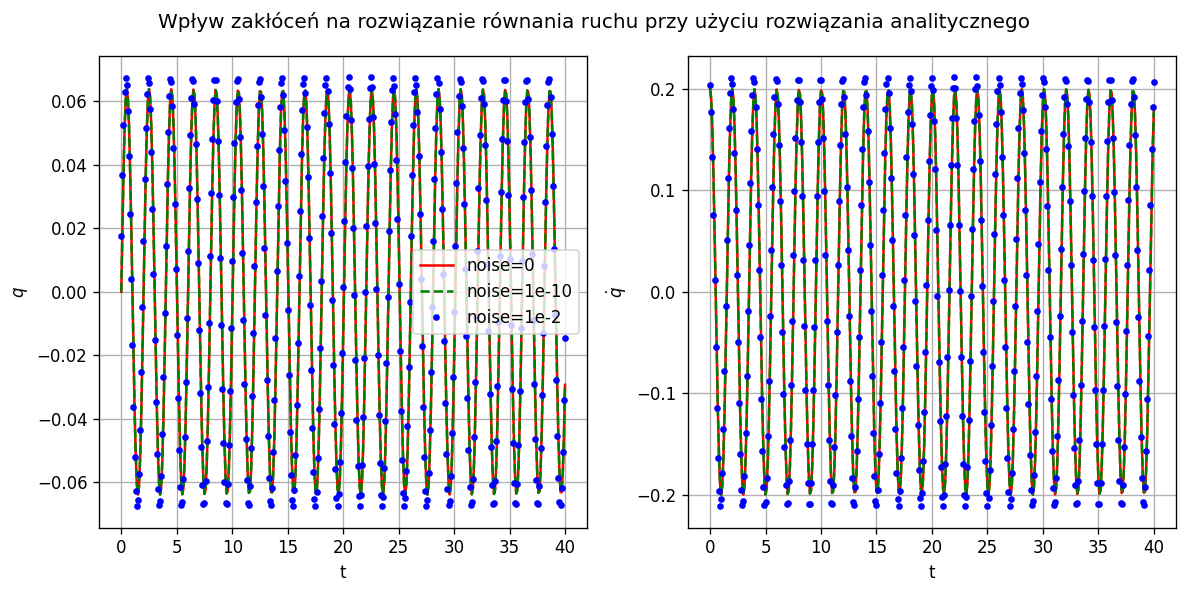

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=120)
fig.suptitle('Wpływ zakłóceń na rozwiązanie równania ruchu przy użyciu rozwiązania analitycznego')

axes[0].plot(t, analitical_clean[:, 0], 'r', label='noise=0')
axes[0].plot(t, analitical_noise1[:, 0], 'g--', label='noise=1e-10')
axes[0].plot(t, analitical_noise2[:, 0], 'b.', label='noise=1e-2')
axes[0].set_xlabel('t')
axes[0].set_ylabel('$q$')
axes[0].legend()
axes[0].grid()

axes[1].plot(t, analitical_clean[:, 1], 'r', label='noise=0')
axes[1].plot(t, analitical_noise1[:, 1], 'g--', label='noise=1e-10')
axes[1].plot(t, analitical_noise2[:, 1], 'b.', label='noise=1e-2')
axes[1].set_xlabel('t')
axes[1].set_ylabel('$\dot q$')
axes[1].grid()

plt.tight_layout()

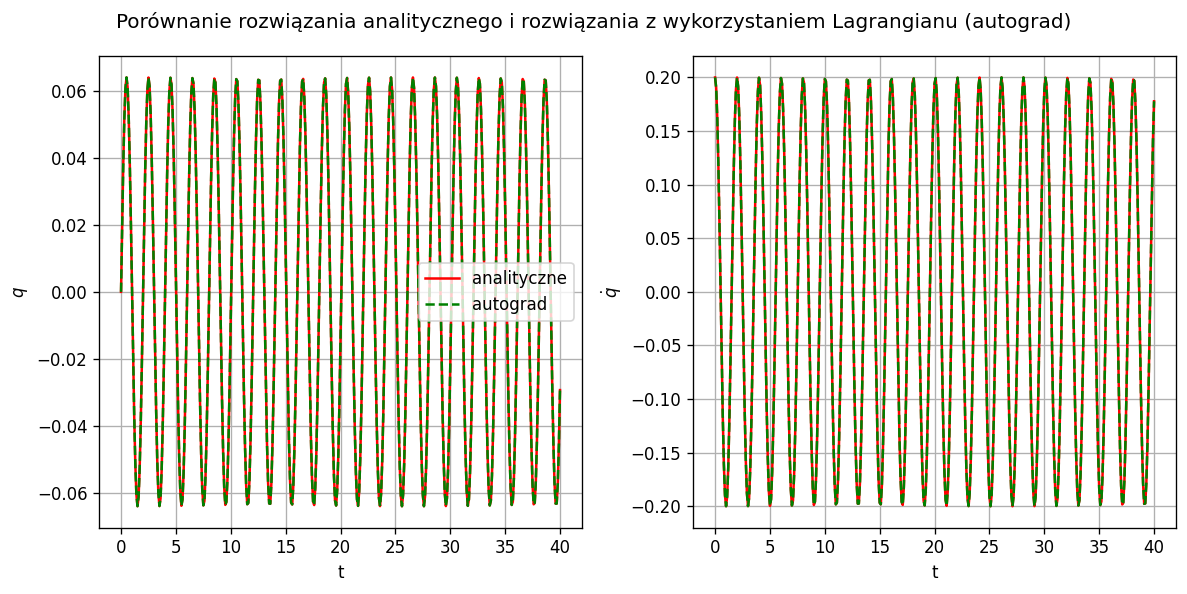

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=120)
fig.suptitle('Porównanie rozwiązania analitycznego i rozwiązania z wykorzystaniem Lagrangianu (autograd)')


axes[0].plot(t, analitical_clean[:, 0], 'r', label='analityczne')
axes[0].plot(t, autograd_clean[:, 0], 'g--', label='autograd')
axes[0].set_xlabel('t')
axes[0].set_ylabel('$q$')
axes[0].legend()
axes[0].grid()


axes[1].plot(t, analitical_clean[:, 1], 'r', label='analityczne')
axes[1].plot(t, autograd_clean[:, 1], 'g--', label='autograd')
axes[1].set_xlabel('t')
axes[1].set_ylabel('$\dot q$')
axes[1].grid()


plt.tight_layout()

In [9]:
#Funkcja normalizująca dane
def normalize(state):
    dim = int(len(state)/2)
    return jnp.concatenate([(state[:dim] + np.pi) % (2 * np.pi) - np.pi, state[dim:]])

In [10]:
#Budowa zbioru uczącego
N=1000
t_train = np.arange(0,N, dtype=np.float32)
t_test = np.arange(N,2*N, dtype=np.float32)

%time x_train = jax.device_get(solve_analitical(x0, t_train))
x_train = jax.device_get(jax.vmap(normalize)(x_train))
%time y_train = jax.device_get(jax.vmap(analitical)(x_train))

%time x_test = jax.device_get(solve_analitical(x_train[-1], t_train))
x_test = jax.device_get(jax.vmap(normalize)(x_test))
%time y_test = jax.device_get(jax.vmap(analitical)(x_test))

CPU times: user 384 ms, sys: 8.62 ms, total: 393 ms
Wall time: 386 ms
CPU times: user 64.3 ms, sys: 1.11 ms, total: 65.4 ms
Wall time: 82 ms
CPU times: user 9.72 ms, sys: 0 ns, total: 9.72 ms
Wall time: 9.56 ms
CPU times: user 11.8 ms, sys: 0 ns, total: 11.8 ms
Wall time: 5.94 ms


In [11]:
# build a neural network model
init_random_params, nn_forward_fn = stax.serial(
    stax.Dense(16),
    stax.Softplus,
    stax.Dense(16),
    stax.Softplus,
    stax.Dense(1),
)

# replace the lagrangian with a parameteric model
def learned_lagrangian(params):
  def lagrangian(q, q_t):
    assert q.shape == (1,)
    state = normalize(jnp.concatenate([q, q_t]))
    return jnp.squeeze(nn_forward_fn(params, state), axis=-1)
  return lagrangian



@jax.jit
def MSE_loss(params, state, targets):
  preds = jax.vmap(partial(equation_of_motion, learned_lagrangian(params)))(state)
  return jnp.mean((preds - targets) ** 2)


In [12]:
%%time

train_error=[]
test_error=[]

rng = jax.random.PRNGKey(0)
output_shape, params_initial = init_random_params(rng, (-1, 2))

init, update, get_params = optimizers.adam(step_size=1e-1)
update = jax.jit(update)
get_params = jax.jit(get_params)


opt_state = init(params_initial)
for i in range(1000):
    params = get_params(opt_state)
    train_error.append(MSE_loss(params, x_train, y_train))
    test_error.append(MSE_loss(params, x_test, y_test))
    grad = jax.grad(MSE_loss)(params, x_train, y_train)
    opt_state = update(i, grad, opt_state)
    if i%100==0:
        print(f"iteration={i}, train_loss={train_error[-1]:.6f}, test_loss={test_error[-1]:.6f}")




iteration=0, train_loss=8.110656, test_loss=8.111710
iteration=100, train_loss=0.103545, test_loss=0.097278
iteration=200, train_loss=0.102439, test_loss=0.096237
iteration=300, train_loss=0.099464, test_loss=0.093440
iteration=400, train_loss=0.121481, test_loss=0.115391
iteration=500, train_loss=0.099572, test_loss=0.093536
iteration=600, train_loss=0.087536, test_loss=0.082214
iteration=700, train_loss=0.000242, test_loss=0.000240
iteration=800, train_loss=0.000188, test_loss=0.000186
iteration=900, train_loss=0.000158, test_loss=0.000157
CPU times: user 27.9 s, sys: 8.69 s, total: 36.6 s
Wall time: 22 s


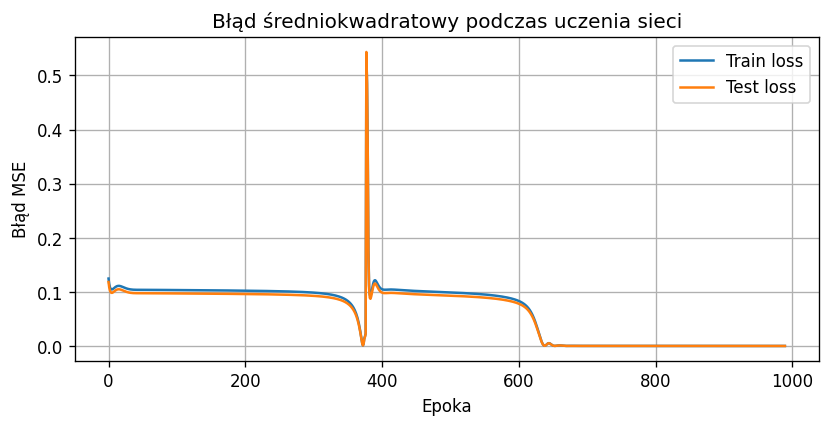

In [13]:
plt.figure(figsize=(8, 3.5), dpi=120)
plt.plot(train_error[10:], label='Train loss')
plt.plot(test_error[10:], label='Test loss')
#plt.yscale('log'))
plt.title('Błąd średniokwadratowy podczas uczenia sieci')
plt.xlabel("Epoka") 
plt.ylabel("Błąd MSE")
plt.grid()
plt.legend() 
plt.show()

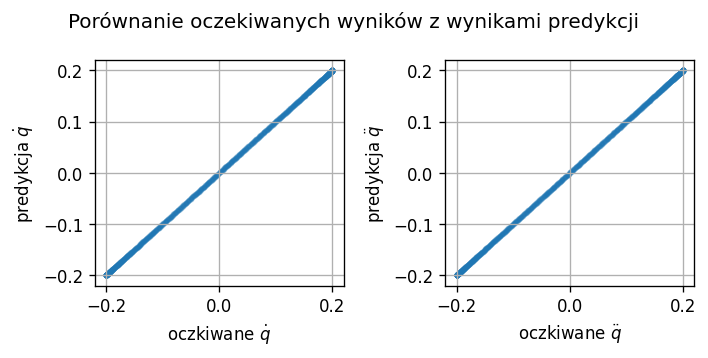

In [14]:
y_pred = jax.vmap(partial(equation_of_motion, learned_lagrangian(params)))(x_test)


fig, axes = plt.subplots(1, 2, figsize=(6, 3), dpi=120)
fig.suptitle("Porównanie oczekiwanych wyników z wynikami predykcji")
axes[0].scatter(y_test[:, 0], y_pred[:, 0], s=6, alpha=0.2)
axes[0].set_xlabel('oczkiwane $\dot q$')
axes[0].set_ylabel('predykcja $\dot q$')
axes[0].grid()
axes[1].scatter(y_test[:, 0], y_pred[:, 0], s=6, alpha=0.2)
axes[1].set_xlabel('oczkiwane $\ddot q$')
axes[1].set_ylabel('predykcja $\ddot q$')
axes[1].grid()
plt.tight_layout()



In [15]:


@partial(jax.jit, backend='cpu')
def solve_lagrangian(params, initial_state, times):
  return odeint(partial(equation_of_motion, learned_lagrangian(params)),
                  initial_state, times, rtol=1e-10, atol=1e-10)


In [16]:
x0 = jnp.array([0,0.2], dtype=np.float32)
t = np.linspace(0, 20, num=201, dtype=np.float32)

%time lagrangian_clean = jax.device_get(solve_lagrangian(params, x0, t))
lagrangian_clean = jax.device_get(jax.vmap(normalize)(lagrangian_clean))

%time analitical_clean = jax.device_get(solve_analitical(x0, t))


CPU times: user 1.32 s, sys: 10.4 ms, total: 1.33 s
Wall time: 1.33 s
CPU times: user 364 ms, sys: 11 ms, total: 375 ms
Wall time: 380 ms


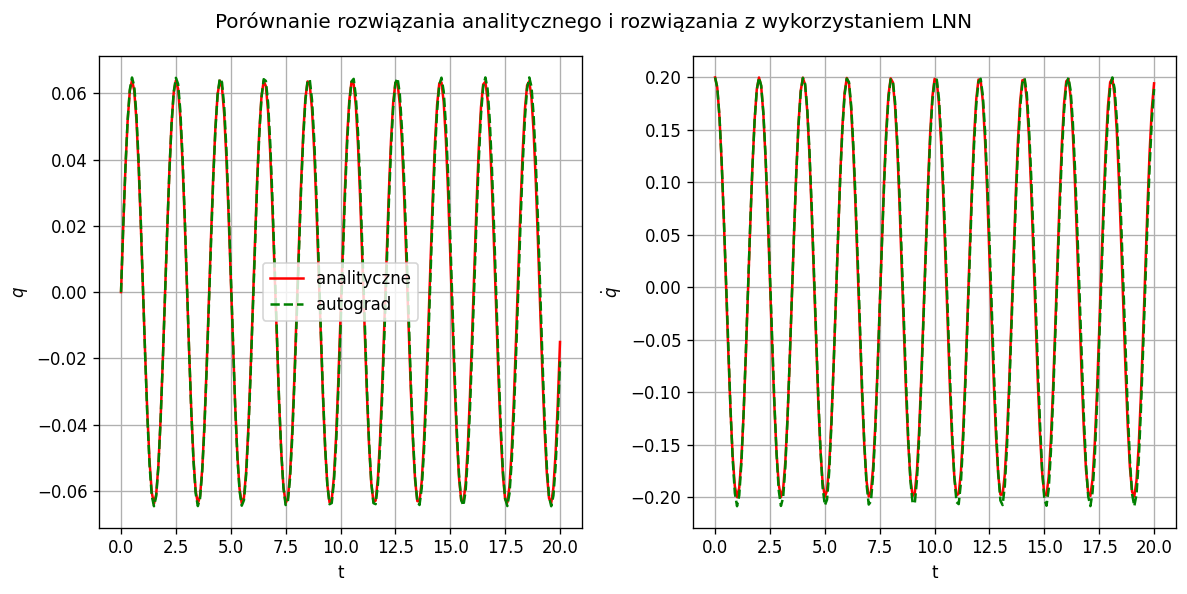

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), dpi=120)
fig.suptitle('Porównanie rozwiązania analitycznego i rozwiązania z wykorzystaniem LNN')


axes[0].plot(t, analitical_clean[:, 0], 'r', label='analityczne')
axes[0].plot(t, lagrangian_clean[:, 0], 'g--', label='autograd')
axes[0].set_xlabel('t')
axes[0].set_ylabel('$q$')
axes[0].legend()
axes[0].grid()


axes[1].plot(t, analitical_clean[:, 1], 'r', label='analityczne')
axes[1].plot(t, lagrangian_clean[:, 1], 'g--', label='autograd')
axes[1].set_xlabel('t')
axes[1].set_ylabel('$\dot q$')
axes[1].grid()

plt.tight_layout()